In [34]:
%matplotlib inline
from utils import *

In [35]:
#path = 'data/redux/'
path = 'data/redux/sample/'
test_path = path + 'test/'
results_path = path + 'results/'

# Dogs vs Cat Redux (part 2)
Based on:

- [1]: lesson1_kt_redux_2.ipynb
- [2]: dogs_cats_redux.ipynb

Steps:
- Finetune and train model
- Generate predictions
- Validate predictions
- Submit predictions to Kaggle

## Finetune and train the model

In [36]:
#batch_size = 64
batch_size = 4

#no_of_epochs = 3
no_of_epochs = 1

In [37]:
vgg = Vgg16()

In [38]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [39]:
vgg.finetune(batches)

** How to train a model **

- Set learning rate lower
- Train for a few epochs
- Save weights (to save time, avoid fitting/training again)

In [12]:
#Set learning rate
vgg.model.optimizer.lr = 0.01

In [13]:
for epoch in range(no_of_epochs):
    print("Running the epoch %d" % epoch)
    vgg.fit(batches, val_batches, nb_epoch=1) # calls self.model.fit_generator
    weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path + weights_filename)

Running the epoch 0
Epoch 1/1
16/16 [==============================] - 256s - loss: 0.9832 - acc: 0.6875 - val_loss: 0.1198 - val_acc: 0.8750


In [41]:
vgg.model.load_weights(results_path + 'ft0.h5')

## Validate predictions

\** Look at "dogs_cats_redux.ipynb", sect. Validate predictions

## Generate predictions

Use the trained model to make predictions on test dataset.

In [42]:
# calls self.model.predict_generator
batches, preds = vgg.test(test_path, batch_size=batch_size*2)

Found 16 images belonging to 1 classes.


In [43]:
#For every image, preds = two probabilities of cats, dogs (based on the order of directories)
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.6765e-02   9.8323e-01]
 [  1.0000e+00   1.4357e-08]
 [  9.9999e-01   5.1616e-06]
 [  9.2710e-06   9.9999e-01]
 [  1.0000e+00   3.2034e-08]]
['unknown/1793.jpg', 'unknown/10840.jpg', 'unknown/1137.jpg', 'unknown/10485.jpg', 'unknown/11115.jpg']


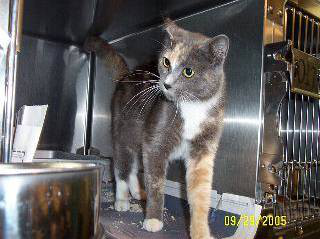

In [44]:
# Verify column order by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [45]:
# Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Submit predictions to Kaggle

In [46]:
# Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

### (1) Adjust probabilities due to evaluation criteria of Kaggle

Kaggle uses a metric called Log Loss to evaluate your submission.

[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) does not support probability values of 0 or 1

- They are undefined (and we have many). 
- Kaggle offsets our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values.

However, log loss rewards predictions that are confident and correct (p=.9999,label=1), 

- but it punishes predictions that are confident and wrong far more (p=.0001,label=1).
- See visualization in *"dogs_cats_redux.ipynb"*

In [53]:
#Get the dog prediction column
isdog = preds[:,1]

In [54]:
#To play it safe, round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

### (2) Format data into Kaggle's submission format

In [58]:
# Extract imageIds from filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
ids[:5]

array([ 1793, 10840,  1137, 10485, 11115])

In [60]:
# Join the two columns into an array of [imageId, isDog]
subm = np.stack([ids, isdog], axis=1)
subm[:5]

array([[  1.7930e+03,   9.5000e-01],
       [  1.0840e+04,   5.0000e-02],
       [  1.1370e+03,   5.0000e-02],
       [  1.0485e+04,   9.5000e-01],
       [  1.1115e+04,   5.0000e-02]])

In [64]:
submission_file_name = 'submission1.csv'
np.savetxt('data/redux/' + submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [65]:
# Show a link to local file so that you can download the file (in case it's on remote server)
from IPython.display import FileLink
FileLink('data/redux/' + submission_file_name)

/home/krit/github-projects/fast-ai/courses/deeplearning1/nbs/data/redux/submission1.csv

To submit to Kaggle:

- download this file and submit on the Kaggle website, or 
- use the Kaggle command line tool's "submit" method.